# Modelling CONCAT
- This notebook uses the data obtained from Pre-Processing notebook

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa
import multiprocessing as mp
import re
import pickle
import time
import random

In [2]:
# Random Seed for Reproducibility
tf.keras.utils.set_random_seed(442)

In [3]:
# GPU Usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Set memory growth
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

Num GPUs Available:  1


2022-05-31 07:55:45.974772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 07:55:46.016836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 07:55:46.017092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
labeldict = {
    'Sadness': 0,
    'Excited': 1,
    'Happiness': 2,
    'Anger' : 3,
    'Frustration' : 4,
    'Other' : 5
}

In [5]:
def one_hot_encode(label):
    one_hot = np.zeros(6)
    one_hot[labeldict[label]] = 1
    return one_hot

In [6]:
def one_hot_encode_list(listOfLabels):
    finalList = []
    for label in listOfLabels:
        finalList.append(one_hot_encode(label))
    return np.array(finalList)

In [7]:
def get_STFT_and_label(path):
    emotion = re.match('.*/DATA/([a-zA-Z]+)/.*', path).groups()[0]
    data, _ = librosa.load(path, sr=44100)
    STFT = np.abs(librosa.stft(data))
    return STFT, emotion

In [8]:
def preprocess_input(pathList): # Returns a list of x (batch_size, timesteps, feature), y (one_hot_encoded)
    with mp.Pool() as p:
        results = p.map(get_STFT_and_label, pathList)
    # Preprocess x:
    x = [item[0] for item in results]
    # Flatten
    x = [item for sublist in x for item in sublist]
    # Zero-padding:
    x = keras.preprocessing.sequence.pad_sequences(x, padding="post", maxlen=1497, dtype = np.float16) # maxlen is after discovering the whole training data
    # Reshaping so that the order is not messed up
    x = x.reshape(-1, 1025, 1497)
    # Transposing so that we have timesteps in dim 1
    x = x.transpose((0, 2, 1))
    # Preprocess y:
    y = [item[1] for item in results]
    # one_hot_encode
    y = one_hot_encode_list(y)
    return x, y

# Loading data: 
- We will load the data per predefined batch size, this is to reduce the memory used for training:

In [9]:
with open('train_paths.pkl', 'rb') as f:
    train_paths = pickle.load(f)
with open('test_paths.pkl', 'rb') as f:
    test_paths = pickle.load(f)

In [10]:
# Make batches of the pathList:
def create_batches(pathList, batch_size):
    ansList = [] # To store the final batched paths
    tempList = [] # Temporary list
    count = 0
    while count < len(pathList):
        tempList.append(pathList[count]) # Append the path
        count += 1
        if (count % batch_size) == 0: # if count is a multiple of batch_size
            ansList.append(tempList)
            tempList = []
    if len(tempList) != 0: # If tempList is not empty
        ansList.append(tempList) # Append the remaining values
    return ansList

# Modelling:

In [11]:
# Keras API:
inp = layers.Input(shape=(1497, 1025)) # Let's make to fixed so that we could use CNN more efficiently

# CNN part:

# For 3D CNN we need to make it in the shape of (batch, height, width, channel)
x = tf.expand_dims(inp, 3)

# first:
x = layers.Conv2D(16, kernel_size=(12,8), padding='same', strides=8)(x)
x = layers.LeakyReLU()(x) # Activation is leaky relu and not relu (See Dying Relu problem that leads to overfitting)
x = layers.MaxPool2D(pool_size=(2,2), padding='same')(x)

# second:
x = layers.Conv2D(32, kernel_size=(8,6), padding='same', strides=6)(x)
x = layers.LeakyReLU()(x) # Activation is leaky relu 
x = layers.MaxPool2D(pool_size=(2,2), padding='same')(x)

# Flattten:
x = layers.Flatten()(x)

# LSTM:
x_LSTM = layers.Masking(mask_value=0.0)(inp)
total_seq1, final_hidden_state1, final_cell_state1 = layers.LSTM(128, return_state=True, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(x_LSTM)
total_seq2, final_hidden_state2, final_cell_state2 = layers.LSTM(128, return_state=True, dropout=0.3, recurrent_dropout=0.3)(total_seq1, initial_state=[final_hidden_state1, final_cell_state1])

x = layers.concatenate([x, final_hidden_state2, final_cell_state2], axis = 1)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(6, activation='softmax')(x)

model = keras.Model(inp, x)

2022-05-31 07:55:47.902641: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-31 07:55:47.903533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 07:55:47.903722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 07:55:47.903849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1497, 1025)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 1497, 1025,   0           ['input_1[0][0]']                
                                1)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 188, 129, 16  1552        ['tf.expand_dims[0][0]']         
                                )                                                             

# Training the model

In [22]:
# Batch_size is 32, epochs = 30
batch_size = 32
epochs = 1

In [15]:
# Optimizer is Stochastic Gradient Descent
# Loss function is Categorical Crossentropy
optimizer = keras.optimizers.Adam() #amsgrad=True
loss_fn = keras.losses.CategoricalCrossentropy()

In [16]:
training_batch = create_batches(train_paths, batch_size=batch_size)
validation_batch = create_batches(test_paths, batch_size=batch_size)

In [17]:
# Metrics:
train_metrics = tf.keras.metrics.CategoricalAccuracy()
validation_metrics = tf.keras.metrics.CategoricalAccuracy()
train_loss = tf.keras.metrics.CategoricalCrossentropy()
validation_loss = tf.keras.metrics.CategoricalCrossentropy()

In [18]:
# A list to store epoch results:
epoch_accuracy_train = []
epoch_accuracy_val = []
epoch_loss_train = []
epoch_loss_val = []

In [19]:
# To speed up, use graph execution
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training = True)
        loss = loss_fn(y, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # Update training accuracy
    train_metrics.update_state(y, y_pred)
    # Update training loss:
    train_loss.update_state(y, y_pred)
    return loss

In [20]:
@tf.function
def valid_step(x, y):
    y_val_pred = model(x, training=False)
    # Update metrics for validation
    validation_metrics.update_state(y, y_val_pred)
    validation_loss.update_state(y, y_val_pred)
    return

In [27]:
# Custom Training loop:
for epoch in range(epochs):
    start_time = time.time()
    print("\nStart of epoch %d" % (epoch))
    # Shuffle the training batch for each epoch:
    random.shuffle(training_batch)
    for step, batch in enumerate(training_batch):
        x, y = preprocess_input(batch)
        
        loss = train_step(x, y)
        
        # Log every 200 batches.
        if step % 10 == 0 and step != 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
    
    # Display metrics at the end of each epoch.
    train_acc = train_metrics.result()
    print("Training acc over epoch: %.4f" % (float(train_acc)))
    loss_train = train_loss.result()
    print("Training loss over epoch: %.4f" % (float(loss_train)))
    
    # Reset training metrics at the end of each epoch
    train_metrics.reset_states()
    train_loss.reset_states()
    
    # For validation data:
    for val_batch in validation_batch:
        x_val, y_val = preprocess_input(val_batch)
        
        valid_step(x_val, y_val)
        

    # Metrics
    val_acc = validation_metrics.result()
    loss_val = validation_loss.result()
    validation_metrics.reset_states()
    validation_loss.reset_states()
    
    # Append to a list for graph:
    epoch_accuracy_train.append(train_acc)
    epoch_accuracy_val.append(val_acc)
    epoch_loss_train.append(loss_train)
    epoch_loss_val.append(loss_val)
    
    print("Validation acc: %.4f" % (float(val_acc)))
    print("Validation loss: %.4f" % (float(loss_val)))
    print("Time taken: %.2fs" % (time.time() - start_time))



Start of epoch 0
Training loss (for one batch) at step 10: 1.0518
Seen so far: 352 samples
Training loss (for one batch) at step 20: 1.0832
Seen so far: 672 samples
Training loss (for one batch) at step 30: 1.1659
Seen so far: 992 samples
Training loss (for one batch) at step 40: 1.0701
Seen so far: 1312 samples
Training loss (for one batch) at step 50: 1.0967
Seen so far: 1632 samples
Training loss (for one batch) at step 60: 0.9619
Seen so far: 1952 samples
Training loss (for one batch) at step 70: 1.2453
Seen so far: 2272 samples
Training loss (for one batch) at step 80: 0.9262
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 1.1921
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 1.0271
Seen so far: 3232 samples
Training loss (for one batch) at step 110: 1.1271
Seen so far: 3552 samples
Training loss (for one batch) at step 120: 1.0472
Seen so far: 3872 samples
Training loss (for one batch) at step 130: 1.1489
Seen so far: 4192 samples
Traini

In [26]:
model.save("CNN_LSTM_CONCAT.h5")

# Plotting:

In [28]:
import matplotlib.pyplot as plt

In [37]:
axis_x = [i+1 for i in range(8)]

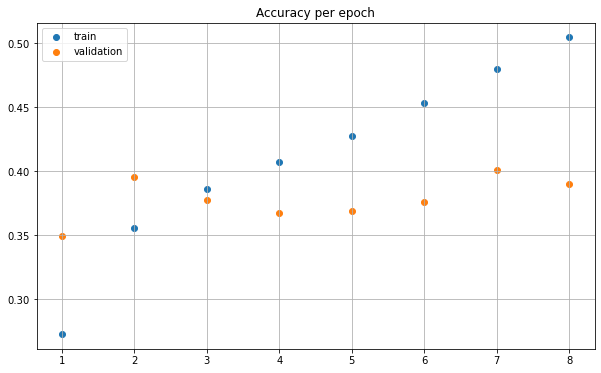

In [38]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x = axis_x, y = epoch_accuracy_train, label = "train")
ax.scatter(x = axis_x, y = epoch_accuracy_val, label="validation")
ax.legend()
ax.grid()
ax.set_title("Accuracy per epoch")
ax.set_xticks(ticks = axis_x)
plt.show()

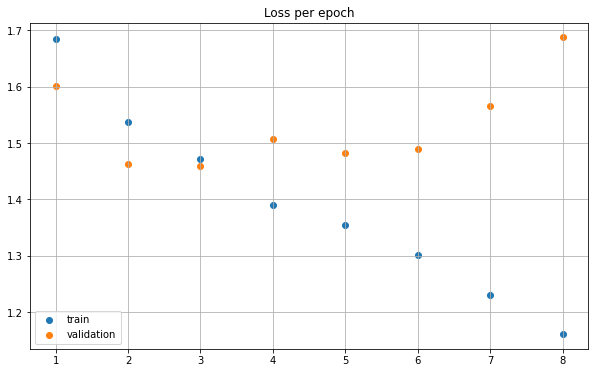

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = axis_x, y = epoch_loss_train, label="train")
ax.scatter(x = axis_x, y = epoch_loss_val, label="validation")
ax.legend()
ax.grid()
ax.set_title("Loss per epoch")
ax.set_xticks(ticks = axis_x)
plt.show()